In [1]:
from collections import namedtuple
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from filterjax import filter_1d

%load_ext autoreload
%autoreload 2

In [2]:
class DogSensor:

    def __init__(self, key, x0=0, velocity=1, noise=0.0):
        self.key = key
        self.x = jnp.array(x0)
        self.velocity = jnp.array(velocity)
        self.noise = jnp.sqrt(noise)

    def sense(self, shape: tuple = (1,)):
        x = []
        for _ in range(shape[0]):
            self.x += self.velocity
            x.append(self.x)
    
        return jnp.array(x) + jax.random.normal(self.key, shape) * self.noise
    
    def filter(self, z, mu1, var1, var2):

        def compute(carry, y):
            mu, var = carry
            # predict
            mu = mu + self.velocity
            var = var + var2
            # update
            mu = (var * y + var2 * mu) / (var + var2)
            var = 1 / (1 / var + 1 / var2)

            return (mu, var), (mu, var)
        
        _, (mu, var) = jax.lax.scan(compute, (mu1, var1), z)

        return mu, var

In [3]:
movement = 1
movement_error = 2
sensor_error = 10
pos = (0, 500)

key = jax.random.PRNGKey(0)
dog = DogSensor(key, x0=pos[0], velocity=movement, noise=sensor_error)
measurements = dog.sense((50,))

pos, var = dog.filter(measurements, pos[0], pos[1], movement_error)

In [8]:
pos2, var2 = filter_1d(
    z=measurements,
    x0=pos[0],
    P=pos[1],
    R=sensor_error,
    Q=movement_error,
    u=movement
)

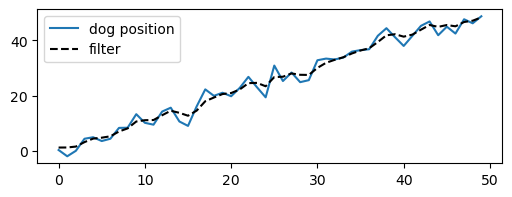

In [9]:
plt.figure(figsize=(6, 2))
plt.plot(jnp.arange(0, len(measurements), 1), measurements, label="dog position")
plt.plot(
    jnp.arange(0, len(measurements), 1), pos2, label="filter", linestyle="--",
    color="black"
)
plt.legend(loc="best")
plt.show()

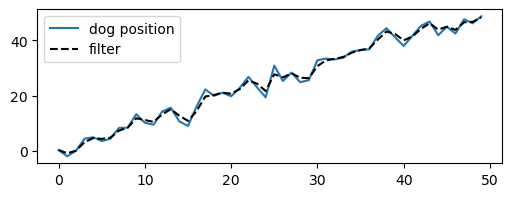

In [6]:
plt.figure(figsize=(6, 2))
plt.plot(jnp.arange(0, len(measurements), 1), measurements, label="dog position")
plt.plot(
    jnp.arange(0, len(measurements), 1), pos, label="filter", linestyle="--",
    color="black"
)
plt.legend(loc="best")
plt.show()